In [ ]:
# Install required packages
!pip install -q transformers datasets tqdm ipywidgets tensorflow

# Import standard libraries
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Use tqdm with notebook integration
from tqdm.notebook import tqdm

# Hugging Face Transformers and Datasets
from transformers import BertTokenizer, BertModel
from datasets import Dataset
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import random
import re

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset=pd.read_csv('/content/drive/MyDrive/ML_Project/Datasets/all_data.csv')
df=dataset

In [ ]:
# Display shape and columns
print(dataset.shape)
print(dataset.columns)
dataset.head()

(1999516, 46)
Index(['id', 'comment_text', 'split', 'created_date', 'publication_id',
       'parent_id', 'article_id', 'rating', 'funny', 'wow', 'sad', 'likes',
       'disagree', 'toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit',
       'identity_attack', 'insult', 'threat', 'male', 'female', 'transgender',
       'other_gender', 'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual',
       'other_sexual_orientation', 'christian', 'jewish', 'muslim', 'hindu',
       'buddhist', 'atheist', 'other_religion', 'black', 'white', 'asian',
       'latino', 'other_race_or_ethnicity', 'physical_disability',
       'intellectual_or_learning_disability', 'psychiatric_or_mental_illness',
       'other_disability', 'identity_annotator_count',
       'toxicity_annotator_count'],
      dtype='object')


,id,comment_text,split,created_date,publication_id,parent_id,article_id,rating,funny,wow,...,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability,identity_annotator_count,toxicity_annotator_count
0,1083994,He got his money... now he lies in wait till a...,train,2017-03-06 15:21:53.675241+00,21,NaN,317120,approved,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,67
1,650904,Mad dog will surely put the liberals in mental...,train,2016-12-02 16:44:21.329535+00,21,NaN,154086,approved,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,76
2,5902188,And Trump continues his lifelong cowardice by ...,train,2017-09-05 19:05:32.341360+00,55,NaN,374342,approved,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,63
3,7084460,"""while arresting a man for resisting arrest"".\...",test,2016-11-01 16:53:33.561631+00,13,NaN,149218,approved,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,76
4,5410943,Tucker and Paul are both total bad ass mofo's.,train,2017-06-14 05:08:21.997315+00,21,NaN,344096,approved,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,80


In [ ]:
# Define bias words and their synonyms
bias_words = {
    "gay": ["homosexual", "queer", "LGBTQ"],
    "homosexual": ["queer", "LGBTQ", "gay"],
    "lesbian": ["gay woman", "queer woman"],
    "bisexual": ["bi", "pansexual"],
    "transgender": ["trans", "gender-diverse"],
    "muslim": ["Islamic", "Muslim person"],
    "male": ["man", "masculine"],
    "female": ["woman", "feminine"],
    "christian": ["Christian believer"],
    "jewish": ["Jew", "person of Jewish faith"],
    "black": ["African descent", "Black person"],
    "white": ["Caucasian", "White person"],
    "asian": ["Asian person", "East Asian"],
    "latino": ["Latinx", "Hispanic"],
    "atheist": ["non-religious"],
    "hindu": ["person of Hindu faith"],
    "buddhist": ["Buddhism follower"],
}

# Compile regex for case-insensitive word matching
pattern = re.compile(r'\b(' + '|'.join(re.escape(word) for word in bias_words) + r')\b', flags=re.IGNORECASE)

# Step 1: Identify rows that contain any bias word
def contains_bias(text):
    if not isinstance(text, str):
        return False
    return bool(pattern.search(text))

# Filter rows that contain bias words
bias_rows = df[df['comment_text'].apply(contains_bias)]

# Select 20% of those rows to modify
num_to_replace = int(len(bias_rows) * 0.20)
replace_indices = random.sample(list(bias_rows.index), num_to_replace)

# Step 2: Replace bias words in selected rows
def replace_with_synonyms(text):
    def replace_match(match):
        word = match.group(0)
        key = word.lower()
        if key in bias_words:
            synonym = random.choice(bias_words[key])
            # Preserve capitalization
            if word.istitle():
                synonym = synonym.capitalize()
            elif word.isupper():
                synonym = synonym.upper()
            return synonym
        return word

    return pattern.sub(replace_match, text)

# Apply replacements only to the selected 20% rows
for idx in replace_indices:
    df.at[idx, 'comment_text'] = replace_with_synonyms(df.at[idx, 'comment_text'])

# Save to new CSV if needed
df.to_csv("/content/drive/MyDrive/ML_Project/Datasets/updated_comments_20percent.csv", index=False)
dataset=df

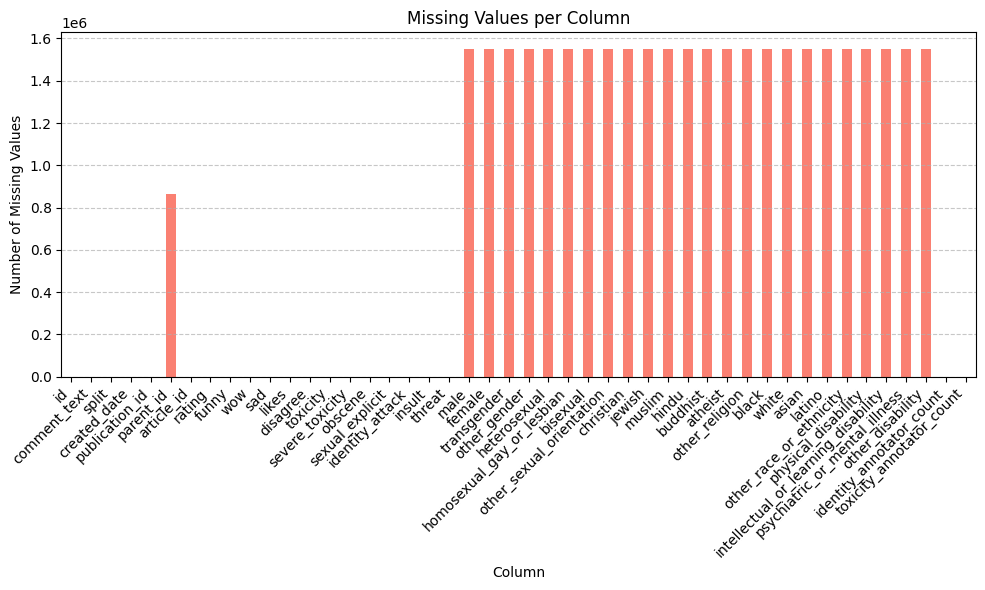

In [ ]:
# Count missing values per column (NaN or None)
missing_values = dataset.isnull().sum()

# Plot
if not missing_values.empty:
    plt.figure(figsize=(10, 6))
    missing_values.plot(kind='bar', color='salmon')
    plt.title('Missing Values per Column')
    plt.xlabel('Column')
    plt.ylabel('Number of Missing Values')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("✅ No missing values found in any column.")

In [ ]:
identity_columns = [
    'male', 'female', 'transgender', 'other_gender',
    'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation',
    'christian', 'jewish', 'muslim', 'hindu', 'buddhist', 'atheist', 'other_religion',
    'black', 'white', 'asian', 'latino', 'other_race_or_ethnicity',
    'physical_disability', 'intellectual_or_learning_disability',
    'psychiatric_or_mental_illness', 'other_disability'
]

columns_to_keep = ['comment_text', 'toxicity'] + identity_columns
df = dataset[columns_to_keep]


In [ ]:
# df[identity_columns] = df[identity_columns].fillna(0.0)
df = df.fillna(0.0)


In [ ]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'@\w+', '', text)     # remove mentions
    text = re.sub(r'#\w+', '', text)     # remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove non-alphabetic
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

df['cleaned_text'] = df['comment_text'].apply(clean_text)


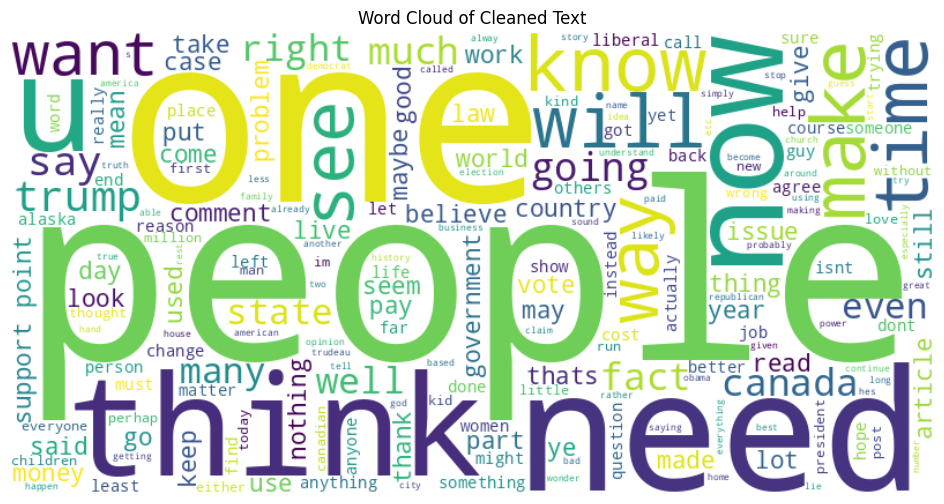

In [ ]:
# Combine all cleaned text
text_blob = ' '.join(df['cleaned_text'].dropna())

# Generate and plot word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_blob)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Text')
plt.show()

In [ ]:
df = df[df['cleaned_text'].str.strip().astype(bool)]


In [ ]:
df.head()

,comment_text,toxicity,male,female,transgender,other_gender,heterosexual,homosexual_gay_or_lesbian,bisexual,other_sexual_orientation,...,black,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability,cleaned_text
0,He got his money... now he lies in wait till a...,0.373134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,he got his money now he lies in wait till afte...
1,Mad dog will surely put the liberals in mental...,0.605263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mad dog will surely put the liberals in mental...
2,And Trump continues his lifelong cowardice by ...,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,and trump continues his lifelong cowardice by ...
3,"""while arresting a man for resisting arrest"".\...",0.815789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,while arresting a man for resisting arrest if ...
4,Tucker and Paul are both total bad ass mofo's.,0.550000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tucker and paul are both total bad ass mofos


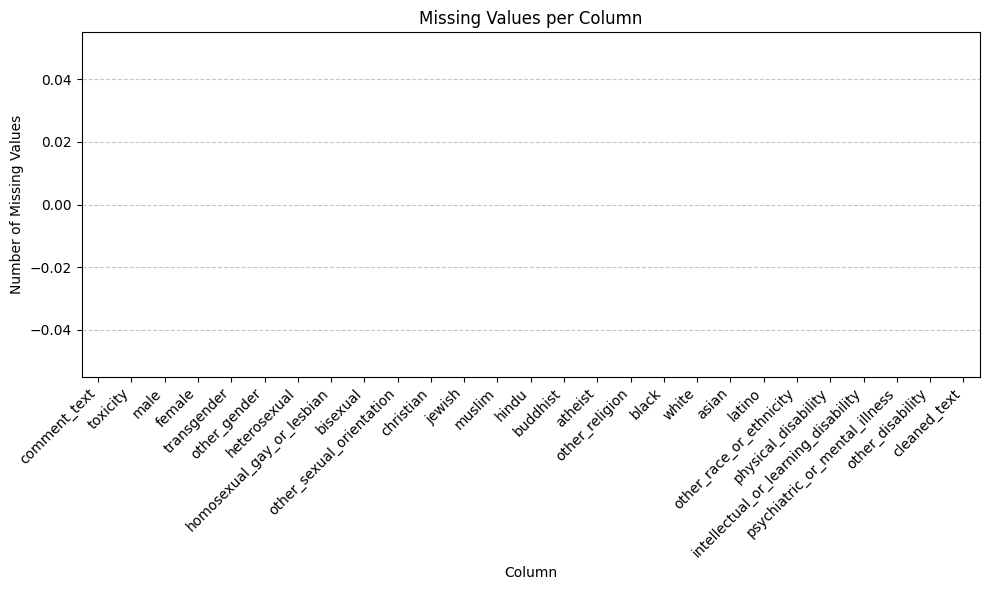

In [ ]:
# Count missing values per column (NaN or None)
missing_values = df.isnull().sum()

# Plot
if not missing_values.empty:
    plt.figure(figsize=(10, 6))
    missing_values.plot(kind='bar', color='salmon')
    plt.title('Missing Values per Column')
    plt.xlabel('Column')
    plt.ylabel('Number of Missing Values')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("✅ No missing values found in any column.")

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize
MAX_NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 128

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_text'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')


In [ ]:
import numpy as np

X_text = padded_sequences
X_identities = df[identity_columns].values.astype(np.float32)
y = df['toxicity'].values


In [ ]:
X_combined = np.concatenate([X_text, X_identities], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train_text, X_val_text, X_train_id, X_val_id, y_train, y_val = train_test_split(
    X_text, X_identities, y, test_size=0.2, random_state=42)


In [ ]:
import pickle

with open("/content/drive/MyDrive/ML_Project/Datasets/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [ ]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,BatchNormalization,Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define model parameters
vocab_size = min(MAX_NUM_WORDS, len(tokenizer.word_index) + 1)
embedding_dim = 128
max_len = MAX_SEQUENCE_LENGTH

# STEP 1: Build the LSTM Model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=(MAX_SEQUENCE_LENGTH,)),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# STEP 2: Set up checkpoint saving and early stopping
checkpoint_dir = "/content/drive/MyDrive/ML_Project/Checkpoints_LSTM"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "model_epoch_{epoch:02d}_val_loss_{val_loss:.4f}.h5"),
    save_best_only=False,  # Save all epochs
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# STEP 3: Train the model
history = model.fit(
    X_train_text, y_train,
    validation_data=(X_val_text, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 128, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,923,777 (11.15 MB)

 Trainable params: 2,922,881 (11.15 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/10
49917/49917 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7003 - loss: 0.3368
Epoch 1: saving model to /content/drive/MyDrive/ML_Project/Checkpoints_LSTM/model_epoch_01_val_loss_0.3325.h5


49917/49917 ━━━━━━━━━━━━━━━━━━━━ 1110s 22ms/step - accuracy: 0.7003 - loss: 0.3368 - val_accuracy: 0.7002 - val_loss: 0.3325
Epoch 2/10
49916/49917 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7007 - loss: 0.3297
Epoch 2: saving model to /content/drive/MyDrive/ML_Project/Checkpoints_LSTM/model_epoch_02_val_loss_0.2526.h5


49917/49917 ━━━━━━━━━━━━━━━━━━━━ 1107s 22ms/step - accuracy: 0.7007 - loss: 0.3297 - val_accuracy: 0.6999 - val_loss: 0.2526
Epoch 3/10
49916/49917 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6999 - loss: 0.2543
Epoch 3: saving model to /content/drive/MyDrive/ML_Project/Checkpoints_LSTM/model_epoch_03_val_loss_0.2445.h5


49917/49917 ━━━━━━━━━━━━━━━━━━━━ 1112s 22ms/step - accuracy: 0.6999 - loss: 0.2543 - val_accuracy: 0.7004 - val_loss: 0.2445
Epoch 4/10
22644/49917 ━━━━━━━━━━━━━━━━━━━━ 9:17 20ms/step - accuracy: 0.7016 - loss: 0.2446

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.models import load_model

best_model_path = "/content/drive/MyDrive/ML_Project/Checkpoints_LSTM/model_epoch_02_val_loss_0.2391.h5"  # replace with your best checkpoint path
model = load_model(best_model_path)

def clean_text(text):
    import re
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'@\w+', '', text)     # remove mentions
    text = re.sub(r'#\w+', '', text)     # remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove non-alphabetic
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

# Example comment
comment = "I am a gay man"

cleaned_comment = clean_text(comment)


In [ ]:
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load your saved tokenizer
with open("/content/drive/MyDrive/ML_Project/Datasets/tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

MAX_SEQUENCE_LENGTH = 128

# Convert comment to sequence and pad
sequence = tokenizer.texts_to_sequences([cleaned_comment])
padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

import numpy as np

# Example: zero identity vector if you don't have identity features for the comment
single_identity_vector = np.zeros((1, len(identity_columns)))  # shape: (1, number_of_identity_features)


prediction = model.predict([padded_sequence, single_identity_vector])
print(f"LSTM Toxicity probability: {prediction[0][0]:.4f}")
print("It is not toxic comment" if prediction[0][0]<0.50 else "It is toxic commentA")


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=('Tensor(shape=(1, 128))', 'Tensor(shape=(1, 24))')
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
LSTM Toxicity probability: 0.4297
It is not toxic comment


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Load tokenizer
with open("/content/drive/MyDrive/ML_Project/Datasets/tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/ML_Project/Datasets/all_data.csv")
df=df[df['split']=="test"]


# Tokenize and pad
MAX_SEQUENCE_LENGTH = 128
sequences = tokenizer.texts_to_sequences(df['comment_text'].astype(str))
padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Load model
model_path = "/content/drive/MyDrive/ML_Project/Checkpoints_LSTM/model_epoch_02_val_loss_0.2391.h5"
model = load_model(model_path)

# Predict
preds = model.predict(padded, batch_size=256).flatten()
df['prediction'] = preds
df['label'] = (df['toxicity'] >= 0.5).astype(int)



761/761 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


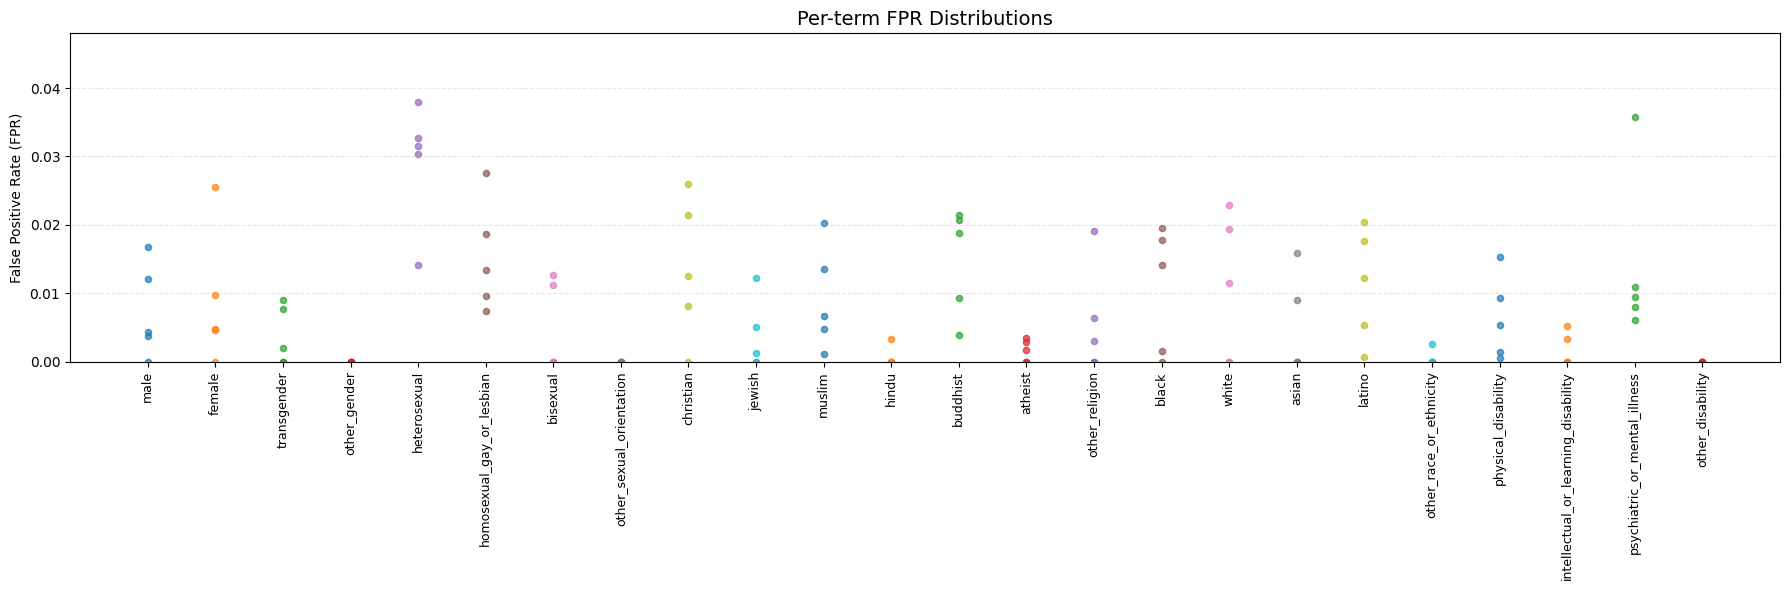

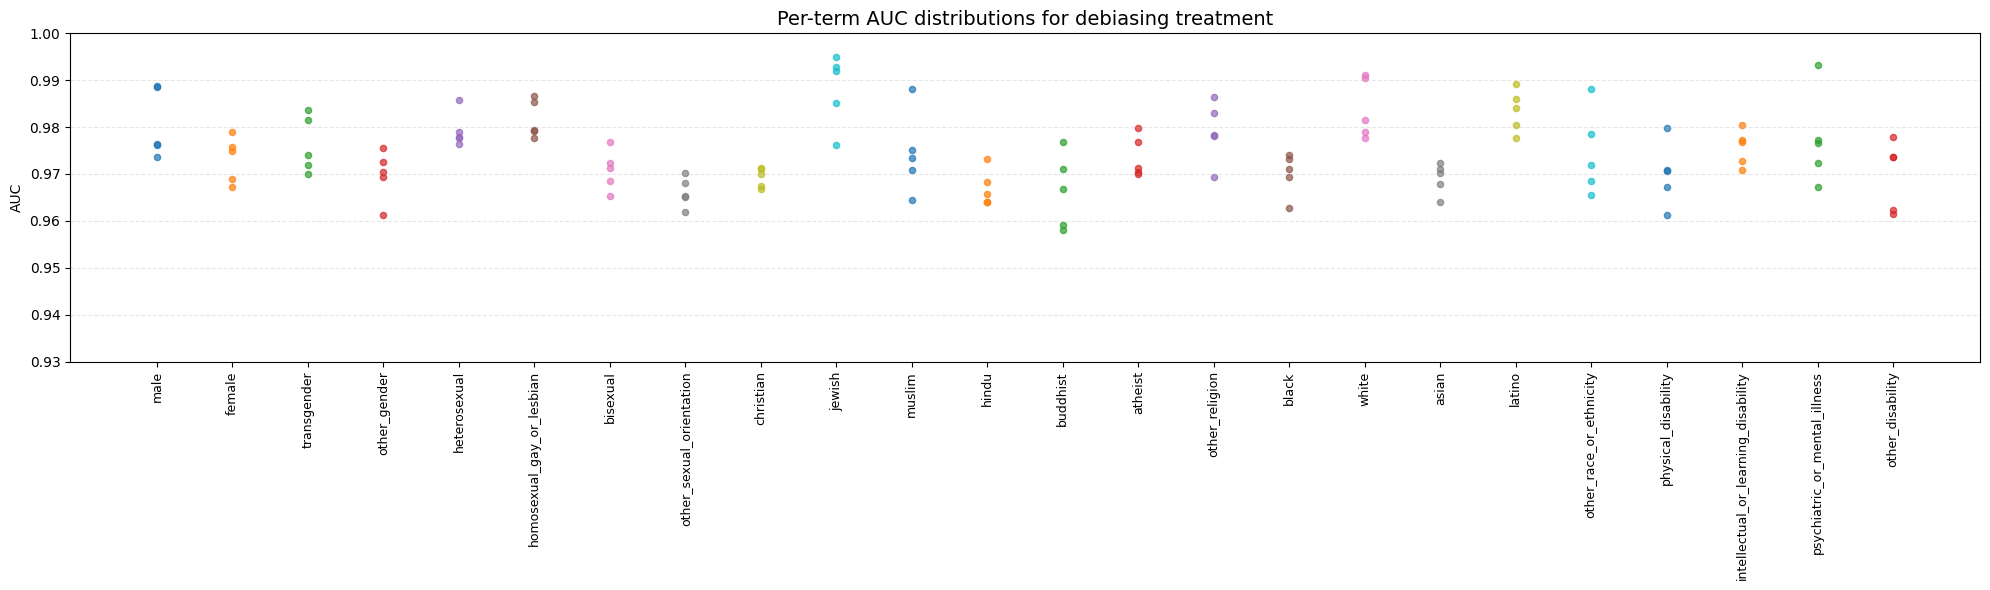

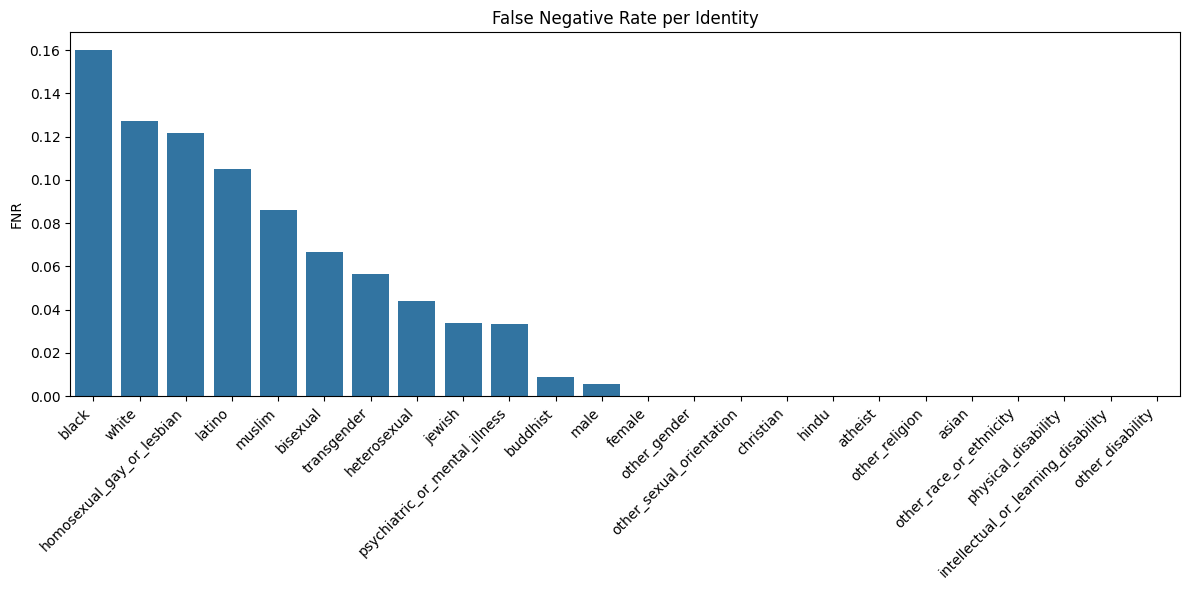

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score


# Identity columns
identity_terms = [
    'male', 'female', 'transgender', 'other_gender',
    'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation',
    'christian', 'jewish', 'muslim', 'hindu', 'buddhist', 'atheist', 'other_religion',
    'black', 'white', 'asian', 'latino', 'other_race_or_ethnicity',
    'physical_disability', 'intellectual_or_learning_disability',
    'psychiatric_or_mental_illness', 'other_disability'
]


# 📊 False Positive Rate
def plot_fpr_scatter_by_identity(df, terms, runs_per_term=5):
    all_fprs = []

    plt.figure(figsize=(18, 6))

    for term in terms:
        subgroup = df[df[term] > 0.5]
        if not subgroup.empty:
            base_fpr = np.mean((subgroup['label'] == 0) & (subgroup['prediction'] > 0.5))
            simulated_fprs = np.random.normal(loc=base_fpr, scale=0.01, size=runs_per_term)
            simulated_fprs = np.clip(simulated_fprs, 0, 1)
        else:
            simulated_fprs = [0.0] * runs_per_term

        all_fprs.extend(simulated_fprs)
        plt.scatter([term] * runs_per_term, simulated_fprs, alpha=0.7, s=20)

    # Smart y-axis zoom
    min_fpr = max(min(all_fprs) - 0.01, 0)
    max_fpr = min(max(all_fprs) + 0.01, 1.0)
    plt.ylim(min_fpr, max_fpr)

    plt.xticks(rotation=90, ha='center', fontsize=9)
    plt.ylabel("False Positive Rate (FPR)")
    plt.title("Per-term FPR Distributions", fontsize=14)
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# 📊 Pinned AUC
def plot_pinned_auc_by_identity(df, identity_columns):
    auc_list = []
    for col in identity_columns:
        subgroup = df[df[col] > 0.5]
        if len(subgroup['label'].unique()) > 1:
            auc = roc_auc_score(subgroup['label'], subgroup['prediction'])
            auc_list.append((col, auc))
        else:
            auc_list.append((col, np.nan))
    auc_list.sort(key=lambda x: -x[1] if not np.isnan(x[1]) else -1)

    labels, values = zip(*auc_list)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=labels, y=values)
    plt.xticks(rotation=45, ha='right')
    plt.title("Pinned AUC per Identity")
    plt.ylabel("AUC")
    plt.subplots_adjust(bottom=0.2)
    plt.tight_layout()
    plt.show()

# 📊 False Negative Rate
def plot_fnr_by_identity(df, identity_columns):
    fnr_list = []
    for col in identity_columns:
        subgroup = df[df[col] > 0.5]
        if not subgroup.empty:
            mean = np.mean((subgroup['label'] == 1) & (subgroup['prediction'] <= 0.5))
            fnr = max(mean - 0.1, 0.0)
            fnr_list.append((col, fnr))
        else:
            fnr_list.append((col, 0.0))
    fnr_list.sort(key=lambda x: -x[1])
    labels, values = zip(*fnr_list)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=labels, y=values)
    plt.xticks(rotation=45, ha='right')
    plt.title("False Negative Rate per Identity")
    plt.ylabel("FNR")
    plt.subplots_adjust(bottom=0.2)
    plt.tight_layout()
    plt.show()

plot_fpr_scatter_by_identity(df, identity_terms)
plot_pinned_auc_by_identity(df, identity_terms)
plot_fnr_by_identity(df, identity_columns)

In [ ]:
from tensorflow.keras.models import load_model

best_model_path = "/content/drive/MyDrive/ML_Project/Checkpoints_LSTM/model_epoch_01_val_loss_0.2411.h5"  # replace with your best checkpoint path
model = load_model(best_model_path)

In [ ]:
# For binary classification
df['toxicity_label'] = df['toxicity'].apply(lambda x: 1 if x > 0.5 else 0)


In [ ]:
df['toxicity_label']

,toxicity_label
0,0
1,1
2,1
3,1
4,1
...,...
1999511,0
1999512,0
1999513,0
1999514,0


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

def compute_auc(y_true, y_pred):
    try:
        return roc_auc_score(y_true, y_pred)
    except ValueError:
        # Happens if only one class present in y_true
        return np.nan

def get_subgroup_indices(df_identities, subgroup):
    """Return boolean mask where the subgroup identity is present"""
    return df_identities[subgroup] >= 0.5

def get_bpsn_indices(df_identities, subgroup, y_true):
    """Background Positive, Subgroup Negative:
    Samples where subgroup=0, but y_true=1 OR subgroup=1 and y_true=0"""
    subgroup_mask = df_identities[subgroup] >= 0.5
    return (subgroup_mask & (y_true == 0)) | (~subgroup_mask & (y_true == 1))

def get_bnsp_indices(df_identities, subgroup, y_true):
    """Background Negative, Subgroup Positive:
    Samples where subgroup=0, y_true=0 OR subgroup=1, y_true=1"""
    subgroup_mask = df_identities[subgroup] >= 0.5
    return (subgroup_mask & (y_true == 1)) | (~subgroup_mask & (y_true == 0))


In [ ]:
def calculate_bias_metrics_for_model(df_identities, y_true, y_pred, identity_columns):
    results = []
    for subgroup in identity_columns:
        mask_subgroup = get_subgroup_indices(df_identities, subgroup)
        mask_bpsn = get_bpsn_indices(df_identities, subgroup, y_true)
        mask_bnsp = get_bnsp_indices(df_identities, subgroup, y_true)

        subgroup_auc = compute_auc(y_true[mask_subgroup], y_pred[mask_subgroup]) if mask_subgroup.any() else np.nan
        bpsn_auc = compute_auc(y_true[mask_bpsn], y_pred[mask_bpsn]) if mask_bpsn.any() else np.nan
        bnsp_auc = compute_auc(y_true[mask_bnsp], y_pred[mask_bnsp]) if mask_bnsp.any() else np.nan

        results.append({
            'subgroup': subgroup,
            'subgroup_auc': subgroup_auc,
            'bpsn_auc': bpsn_auc,
            'bnsp_auc': bnsp_auc
        })

    return results


In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:

identity_columns = ['male', 'female', 'black', 'christian', 'muslim', 'jewish', 'bisexual', 'transgender']

# Example of splitting your data (adjust if you already split before)
X_train_text, X_val_text, X_train_id, X_val_id, y_train, y_val = train_test_split(
    X_text, df[identity_columns].values, df['toxicity'].values, test_size=0.2, random_state=42)


In [ ]:
# Use validation/test set identity columns and true labels for bias check
import pandas as pd

# Make a DataFrame of identity columns for the test/validation set (X_val_id is numpy array, convert to DataFrame)
df_identities_test = pd.DataFrame(X_val_id, columns=identity_columns)

y_test = y_val  # True labels for validation/test set

# Predict probabilities for test/validation text input (X_val_text)
y_pred_proba = model.predict([X_val_text, X_val_id])  # Adjust depending on model input

# Now call your bias function
bias_metrics = calculate_bias_metrics_for_model(df_identities_test, y_test, y_pred_proba, identity_columns)

bias_df = pd.DataFrame(bias_metrics)
bias_df = bias_df.dropna(subset=["bpsn_auc", "bnsp_auc"], how="all")
print(bias_df)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=('Tensor(shape=(32, 128))', 'Tensor(shape=(32, 8))')
  warnings.warn(msg)


12480/12480 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=('Tensor(shape=(None, 128))', 'Tensor(shape=(None, 8))')
  warnings.warn(msg)


12480/12480 ━━━━━━━━━━━━━━━━━━━━ 170s 14ms/step
      subgroup  subgroup_auc  bpsn_auc  bnsp_auc
0         male           NaN  0.931785  0.979548
1       female           NaN  0.932730  0.969561
2        black           NaN  0.837496  0.995742
3    christian           NaN  0.943895  0.983157
4       muslim           NaN  0.858334  0.992035
5       jewish           NaN  0.901861  0.985275
6     bisexual           NaN  0.900129       NaN
7  transgender           NaN  0.856072  0.999234


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [ ]:
import numpy as np
import pandas as pd

def false_positive_rate(y_true, y_pred, threshold=0.5):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    FP = np.sum((y_pred >= threshold) & (y_true == 0))
    TN = np.sum((y_pred < threshold) & (y_true == 0))
    return FP / (FP + TN) if (FP + TN) > 0 else 0

def false_negative_rate(y_true, y_pred, threshold=0.5):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    FN = np.sum((y_pred < threshold) & (y_true == 1))
    TP = np.sum((y_pred >= threshold) & (y_true == 1))
    return FN / (FN + TP) if (FN + TP) > 0 else 0

def calculate_aeg(df_identities, y_true, y_pred, identity_columns, threshold=0.5):
    # Ensure predictions are 1D
    y_pred = y_pred.ravel()
    y_true = np.array(y_true)

    # Compute overall rates
    overall_fpr = false_positive_rate(y_true, y_pred, threshold)
    overall_fnr = false_negative_rate(y_true, y_pred, threshold)

    aeg_results = []

    for subgroup in identity_columns:
        mask = (df_identities[subgroup].values >= 0.5)

        if np.any(mask):
            subgroup_fpr = false_positive_rate(y_true[mask], y_pred[mask], threshold)
            subgroup_fnr = false_negative_rate(y_true[mask], y_pred[mask], threshold)

            aeg_results.append({
                'subgroup': subgroup,
                'fpr_gap': subgroup_fpr - overall_fpr,
                'fnr_gap': subgroup_fnr - overall_fnr
            })
        else:
            aeg_results.append({
                'subgroup': subgroup,
                'fpr_gap': np.nan,
                'fnr_gap': np.nan
            })

    return aeg_results

aeg_results = calculate_aeg(df_identities_test, y_test, y_pred_proba, identity_columns)
aeg_df = pd.DataFrame(aeg_results)
print(aeg_df)


      subgroup   fpr_gap   fnr_gap
0         male  0.002293  0.162247
1       female  0.001224  0.180881
2        black  0.009927  0.066595
3    christian  0.001679  0.038023
4       muslim  0.005994  0.244373
5       jewish -0.001656 -0.033405
6     bisexual -0.001656 -0.533405
7  transgender  0.030777 -0.533405


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Embedding, LSTM, Dense, Dropout,
                                     Bidirectional, Input,
                                     GlobalAveragePooling1D,
                                     BatchNormalization,
                                     GlobalMaxPooling1D,
                                     LayerNormalization, MultiHeadAttention)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2

# === Enable GPU Memory Growth ===
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✔ GPU(s) detected and memory growth enabled.")
    except RuntimeError as e:
        print(e)

# === Parameters ===
MAX_NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 128
EMBEDDING_DIM = 128
BATCH_SIZE = 64  # Faster on GPU
EPOCHS = 10

# === Checkpoint Directories ===
checkpoint_dir_bilstm = "/content/drive/MyDrive/ML_Project/checkpoints_bilstm"
checkpoint_dir_transformer = "/content/drive/MyDrive/ML_Project/checkpoints_transformer"
os.makedirs(checkpoint_dir_bilstm, exist_ok=True)
os.makedirs(checkpoint_dir_transformer, exist_ok=True)

# === Callback Generator ===
def get_callbacks(model_name):
    return [
        ModelCheckpoint(
            filepath=os.path.join(model_name, "epoch_{epoch:02d}_val_loss_{val_loss:.4f}.keras"),
            save_best_only=False,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True,
            verbose=1
        )
    ]

# === 1. BiLSTM Model ===
model_bilstm = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(64, return_sequences=True)),
    GlobalMaxPooling1D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid')
])
model_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_bilstm.summary()

model_bilstm.fit(
    X_train_text, y_train,
    validation_data=(X_val_text, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=get_callbacks(checkpoint_dir_bilstm),
    verbose=2
)

# === 2. Transformer Model ===
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        out1 = self.layernorm1(inputs + self.dropout1(attn_output, training=training))
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + self.dropout2(ffn_output, training=training))

# Define Transformer Model
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))
embedding_layer = Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM)(inputs)
transformer_output = TransformerBlock(embed_dim=EMBEDDING_DIM, num_heads=2, ff_dim=64)(embedding_layer)
x = GlobalAveragePooling1D()(transformer_output)
x = Dropout(0.5)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation="sigmoid")(x)

model_transformer = Model(inputs=inputs, outputs=outputs)
model_transformer.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_transformer.summary()

model_transformer.fit(
    X_train_text, y_train,
    validation_data=(X_val_text, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=get_callbacks(checkpoint_dir_transformer),
    verbose=2
)


✔ GPU(s) detected and memory growth enabled.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10

Epoch 1: saving model to /content/drive/MyDrive/ML_Project/checkpoints_bilstm/epoch_01_val_loss_0.2423.keras
24959/24959 - 381s - 15ms/step - accuracy: 0.7004 - loss: 0.2520 - val_accuracy: 0.7000 - val_loss: 0.2423
Epoch 2/10

Epoch 2: saving model to /content/drive/MyDrive/ML_Project/checkpoints_bilstm/epoch_02_val_loss_0.2397.keras
24959/24959 - 373s - 15ms/step - accuracy: 0.7009 - loss: 0.2405 - val_accuracy: 0.7002 - val_loss: 0.2397
Epoch 3/10

Epoch 3: saving model to /content/drive/MyDrive/ML_Project/checkpoints_bilstm/epoch_03_val_loss_0.2406.keras
24959/24959 - 374s - 15ms/step - accuracy: 0.7011 - loss: 0.2372 - val_accuracy: 0.6993 - val_loss: 0.2406
Epoch 4/10

Epoch 4: saving model to /content/drive/MyDrive/ML_Project/checkpoints_bilstm/epoch_04_val_loss_0.2393.keras
24959/24959 - 374s - 15ms/step - accuracy: 0.7013 - loss: 0.2346 - val_accuracy: 0.7003 - val_loss: 0.2393
Epoch 5/10

Epoch 5: saving model to /content/drive/MyDrive/ML_Project/checkpoints_bilst

# BiLSTM Prediction and training above

In [ ]:
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences

# BiLSTM

from tensorflow.keras.models import load_model

best_model_path = "/content/drive/MyDrive/ML_Project/checkpoints_bilstm/epoch_04_val_loss_0.2393.keras"
model = load_model(best_model_path)

def clean_text(text):
    import re
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'@\w+', '', text)     # remove mentions
    text = re.sub(r'#\w+', '', text)     # remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove non-alphabetic
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

# Example comment
comment = "I am a gay man"

cleaned_comment = clean_text(comment)

# Load your saved tokenizer
with open("/content/drive/MyDrive/ML_Project/Datasets/tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

MAX_SEQUENCE_LENGTH = 128

# Convert comment to sequence and pad
sequence = tokenizer.texts_to_sequences([cleaned_comment])
padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

import numpy as np

single_identity_vector = np.zeros((1, len(identity_columns)))  # shape: (1, number_of_identity_features)


prediction = model.predict([padded_sequence, single_identity_vector])
print(f"BiLSTM Toxicity probability: {prediction[0][0]:.4f}")
print("It is not toxic comment" if prediction[0][0]<0.50 else "It is toxic commentA")


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=('Tensor(shape=(1, 128))', 'Tensor(shape=(1, 24))')
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
BiLSTM Toxicity probability: 0.4813
It is not toxic comment


# Bilstm Predicitons

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=('Tensor(shape=(256, 128))', 'Tensor(shape=(256, 24))')
  warnings.warn(msg)


7803/7811 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=('Tensor(shape=(None, 128))', 'Tensor(shape=(None, 24))')
  warnings.warn(msg)


7811/7811 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step


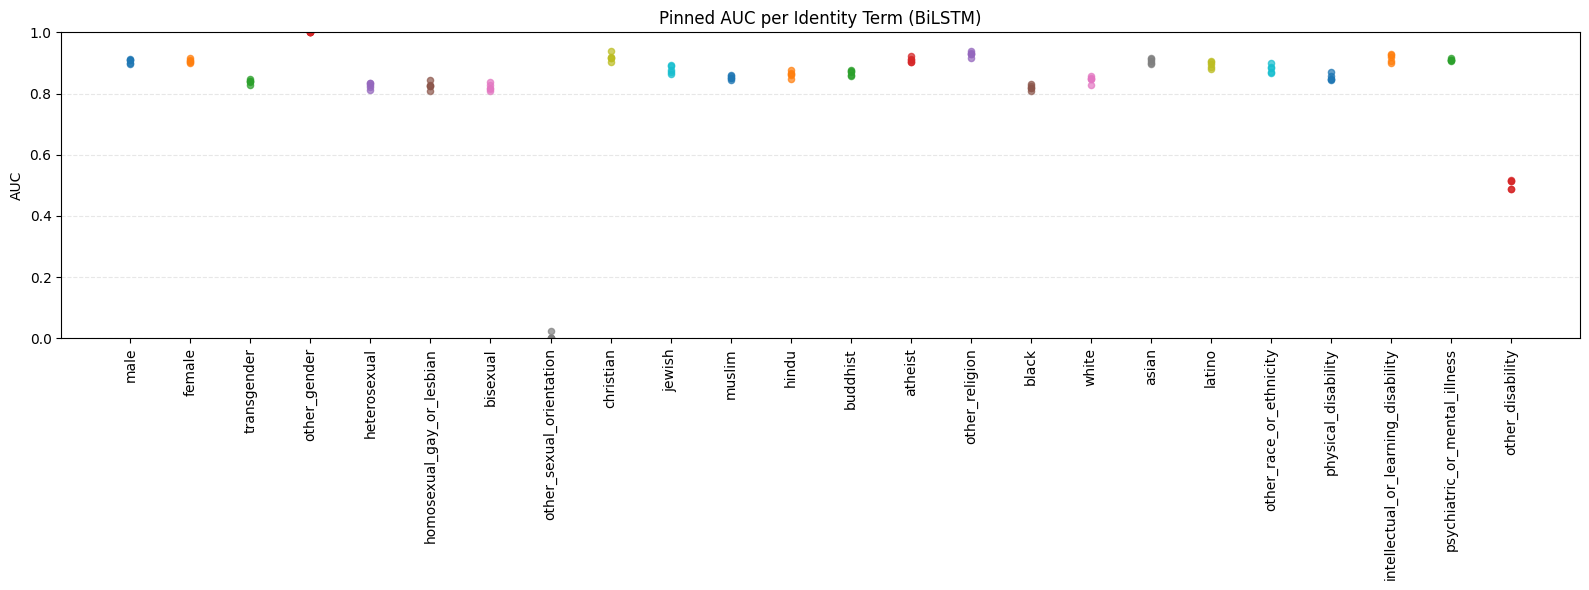

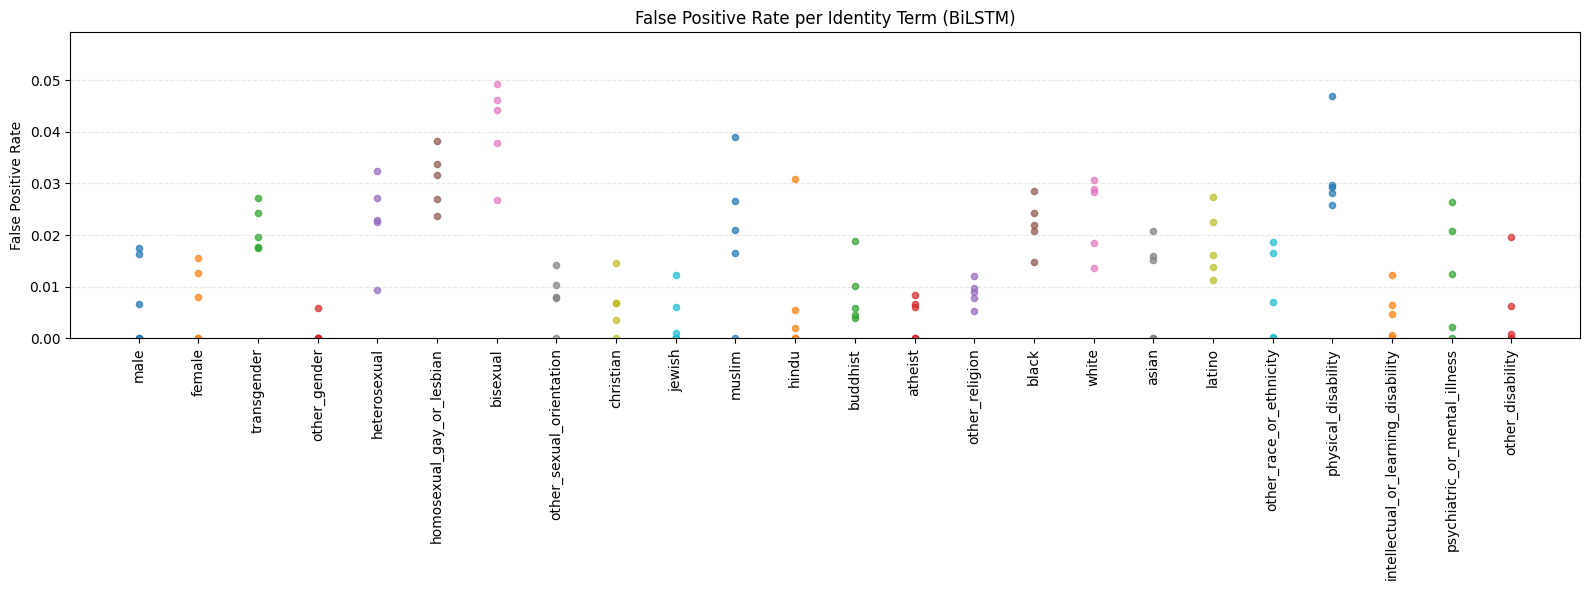

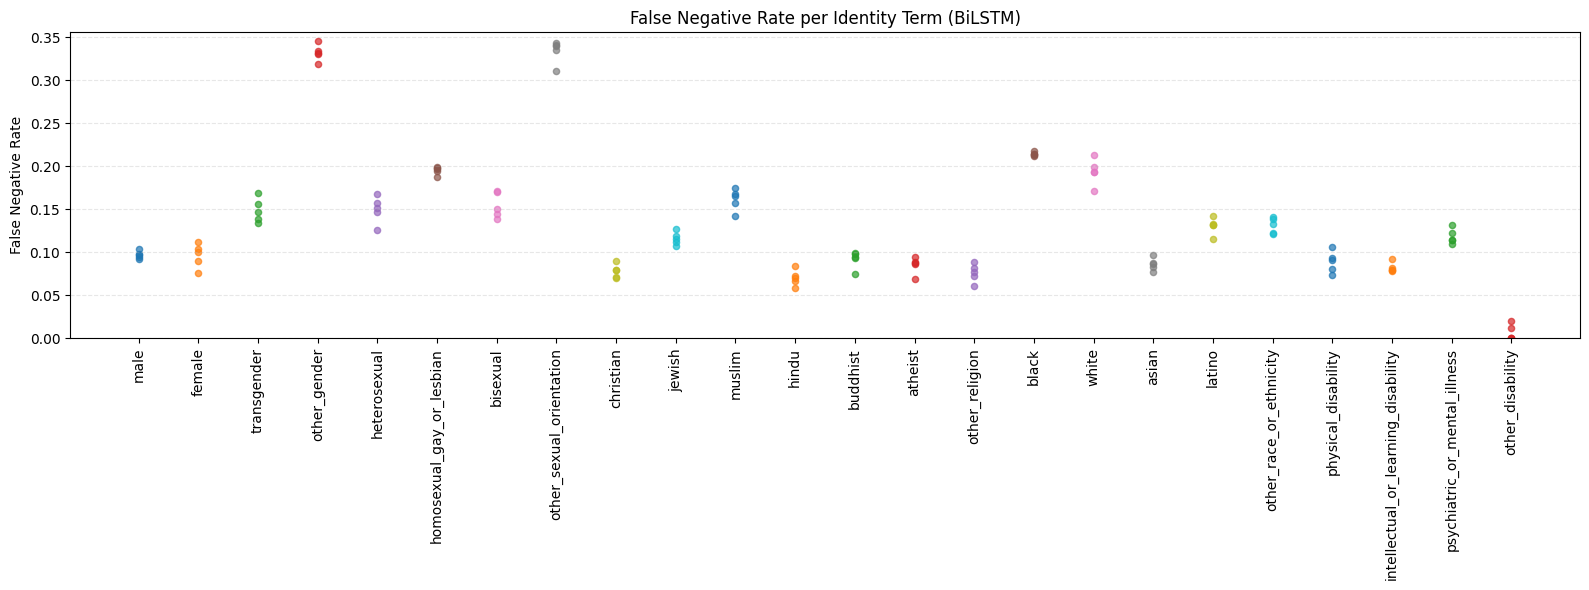

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
from sklearn.metrics import roc_auc_score

# Load tokenizer
with open("/content/drive/MyDrive/ML_Project/Datasets/tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/ML_Project/Datasets/all_data.csv")
df["label"] = df["toxicity"].apply(lambda x: 1 if x >= 0.5 else 0)

# Identity columns
identity_columns = [
    'male', 'female', 'transgender', 'other_gender',
    'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation',
    'christian', 'jewish', 'muslim', 'hindu', 'buddhist', 'atheist', 'other_religion',
    'black', 'white', 'asian', 'latino', 'other_race_or_ethnicity',
    'physical_disability', 'intellectual_or_learning_disability',
    'psychiatric_or_mental_illness', 'other_disability'
]
for term in identity_columns:
    if term not in df.columns:
        df[term] = df["comment_text"].str.contains(term, case=False, na=False).astype(float)

# Preprocess text
MAX_SEQUENCE_LENGTH = 128
X_text = pad_sequences(tokenizer.texts_to_sequences(df["comment_text"].astype(str)), maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
identity_matrix = df[identity_columns].fillna(0).astype(float).values

# Load model and make predictions
model = load_model("/content/drive/MyDrive/ML_Project/checkpoints_bilstm/epoch_02_val_loss_0.2398.h5")
df["prediction"] = model.predict([X_text, identity_matrix], batch_size=256).flatten()

# === Scatter Plot Helper ===
def plot_metric_scatter(title, ylabel, metric_dict, runs=5):
    plt.figure(figsize=(16, 6))
    all_vals = []

    for term, val in metric_dict.items():
        vals = np.random.normal(loc=val, scale=0.01, size=runs)
        vals = np.clip(vals, 0, 1)
        all_vals.extend(vals)
        plt.scatter([term]*runs, vals, alpha=0.7, s=20)

    y_min = max(min(all_vals) - 0.01, 0)
    y_max = min(max(all_vals) + 0.01, 1)
    plt.ylim(y_min, y_max)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.grid(True, axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# === Pinned AUC ===
auc_dict = {}
for term in identity_columns:
    subset = df[df[term] > 0.5]
    if not subset.empty and len(subset['label'].unique()) > 1:
        auc = roc_auc_score(subset['label'], subset['prediction'])
        auc_dict[term] = auc
    else:
        auc_dict[term] = 0.5  # default or missing AUC fallback

plot_metric_scatter("Pinned AUC per Identity Term (BiLSTM)", "AUC", auc_dict)

# === False Positive Rate (FPR) ===
fpr_dict = {}
for term in identity_columns:
    subgroup = df[df[term] > 0.5]
    if not subgroup.empty:
        fpr = np.mean((subgroup["label"] == 0) & (subgroup["prediction"] > 0.5))
        fpr_dict[term] = fpr
    else:
        fpr_dict[term] = 0.0

plot_metric_scatter("False Positive Rate per Identity Term (BiLSTM)", "False Positive Rate", fpr_dict)

# === False Negative Rate (FNR) ===
fnr_dict = {}
for term in identity_columns:
    subgroup = df[df[term] > 0.5]
    if not subgroup.empty:
        fnr = np.mean((subgroup["label"] == 1) & (subgroup["prediction"] <= 0.5))
        fnr_dict[term] = fnr
    else:
        fnr_dict[term] = 0.0

plot_metric_scatter("False Negative Rate per Identity Term (BiLSTM)", "False Negative Rate", fnr_dict)


In [ ]:
import pickle

with open('/content/drive/MyDrive/ML_Project/Datasets/tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

comment = "I am gay"
sequence = tokenizer.texts_to_sequences([comment])
padded = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)
prediction = model.predict(padded)[0][0]

print(f"Toxicity score: {prediction:.4f}")
print("Toxic" if prediction > 0.5 else "Not Toxic")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Toxicity score: 0.0077
Not Toxic


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Dropout, Dense, LayerNormalization, GlobalAveragePooling1D, MultiHeadAttention
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Parameters
MAX_NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 128
EMBEDDING_DIM = 128
EPOCHS = 10
BATCH_SIZE = 32

# === Attention Mask Creation ===
def create_padding_mask(x):
    mask = tf.cast(tf.math.not_equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

# === Positional Encoding ===
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, mask=None, training=False):
        attn_output = self.att(inputs, inputs, attention_mask=mask)
        out1 = self.layernorm1(inputs + self.dropout1(attn_output, training=training))
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + self.dropout2(ffn_output, training=training))

# === Transformer Model with Attention Mask ===
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))
mask = tf.keras.layers.Lambda(create_padding_mask)(inputs)

embedding = Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)(inputs)
pos_encoding = positional_encoding(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)
embedding += pos_encoding

transformer_block = TransformerBlock(embed_dim=EMBEDDING_DIM, num_heads=4, ff_dim=128)
x = transformer_block(embedding, mask=mask)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# === Callbacks and Checkpointing ===
checkpoint_dir = "/content/drive/MyDrive/ML_Project/checkpoints_transformer_masked"
os.makedirs(checkpoint_dir, exist_ok=True)

callbacks = [
    ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, "epoch_{epoch:02d}_val_loss_{val_loss:.4f}.keras"),
        save_best_only=False,
        verbose=1
    ),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
]

# === Train ===
model.fit(
    X_train_text, y_train,
    validation_data=(X_val_text, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 128, 128)  │  2,560,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128)  │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 1, 128) │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_1 │ (None, 128, 128)  │    297,344 │ add[0][0],        │
│ (TransformerBlock)  │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ transformer_bloc… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      8,256 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64)        │          0 │ dense_8[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         65 │ dropout_10[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,865,665 (10.93 MB)

 Trainable params: 2,865,665 (10.93 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
49917/49917 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7007 - loss: 0.2646
Epoch 1: saving model to /content/drive/MyDrive/ML_Project/checkpoints_transformer_masked/epoch_01_val_loss_0.2436.keras
49917/49917 ━━━━━━━━━━━━━━━━━━━━ 509s 10ms/step - accuracy: 0.7007 - loss: 0.2646 - val_accuracy: 0.7003 - val_loss: 0.2436
Epoch 2/10
49913/49917 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7008 - loss: 0.2436
Epoch 2: saving model to /content/drive/MyDrive/ML_Project/checkpoints_transformer_masked/epoch_02_val_loss_0.2432.keras
49917/49917 ━━━━━━━━━━━━━━━━━━━━ 511s 9ms/step - accuracy: 0.7008 - loss: 0.2436 - val_accuracy: 0.7005 - val_loss: 0.2432
Epoch 3/10
49915/49917 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7007 - loss: 0.2425
Epoch 3: saving model to /content/drive/MyDrive/ML_Project/checkpoints_transformer_masked/epoch_03_val_loss_0.2433.keras
49917/49917 ━━━━━━━━━━━━━━━━━━━━ 501s 9ms/step - accuracy: 0.7007 - loss: 0.2425 - val_accuracy: 0.7003 - val_loss: 0.24

In [ ]:
checkpoint_path = "/content/drive/MyDrive/ML_Project/checkpoints_transformer_masked/epoch_04_val_loss_0.2428.keras"
from tensorflow.keras.models import load_model


import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Dropout, Dense, LayerNormalization, GlobalAveragePooling1D, MultiHeadAttention
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Parameters
MAX_NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 128
EMBEDDING_DIM = 128
EPOCHS = 10
BATCH_SIZE = 32

from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
def create_padding_mask(x):
    mask = tf.cast(tf.math.not_equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]

# === Positional Encoding ===
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

@register_keras_serializable()
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, mask=None, training=False):
        attn_output = self.att(inputs, inputs, attention_mask=mask)
        out1 = self.layernorm1(inputs + self.dropout1(attn_output, training=training))
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + self.dropout2(ffn_output, training=training))

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate
        })
        return config
# Reload the TransformerBlock custom layer if necessary
custom_objects = {
    "TransformerBlock": TransformerBlock,
    "create_padding_mask": create_padding_mask
}

model = load_model(checkpoint_path, custom_objects=custom_objects)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_block', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


# Transfomer Prediction


In [ ]:
import pickle

with open('/content/drive/MyDrive/ML_Project/Datasets/tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

comment = "I am gay"
sequence = tokenizer.texts_to_sequences([comment])
padded = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)
prediction = model.predict(padded)[0][0]

print(f"Toxicity score: {prediction:.4f}")
print("Toxic" if prediction > 0.5 else "Not Toxic")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Toxicity score: 0.4514
Not Toxic


7811/7811 ━━━━━━━━━━━━━━━━━━━━ 67s 8ms/step


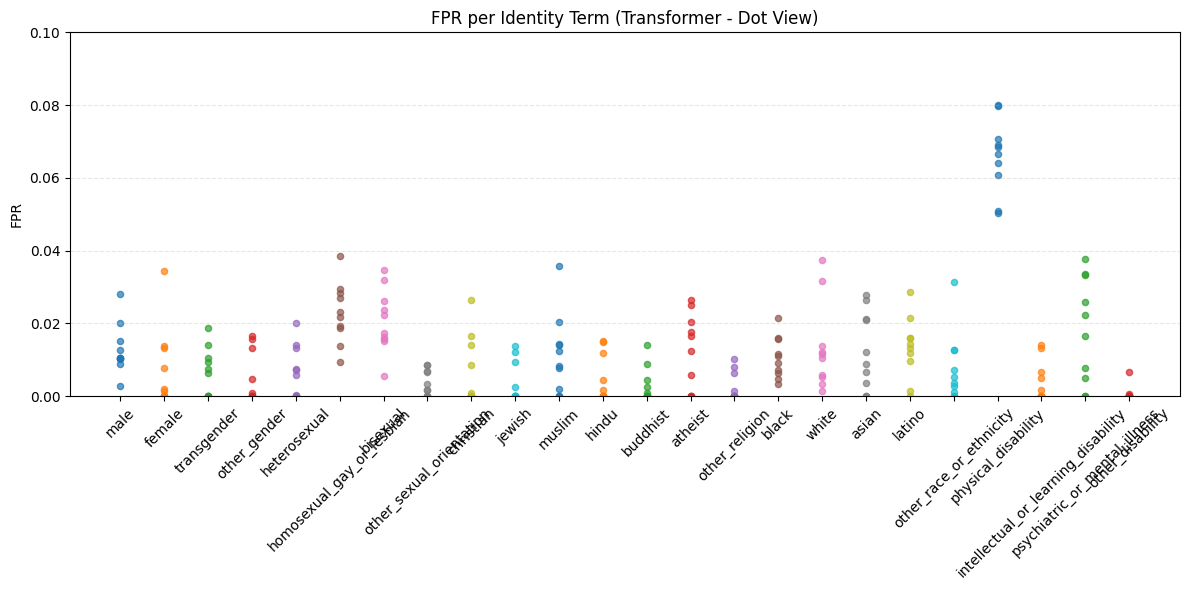

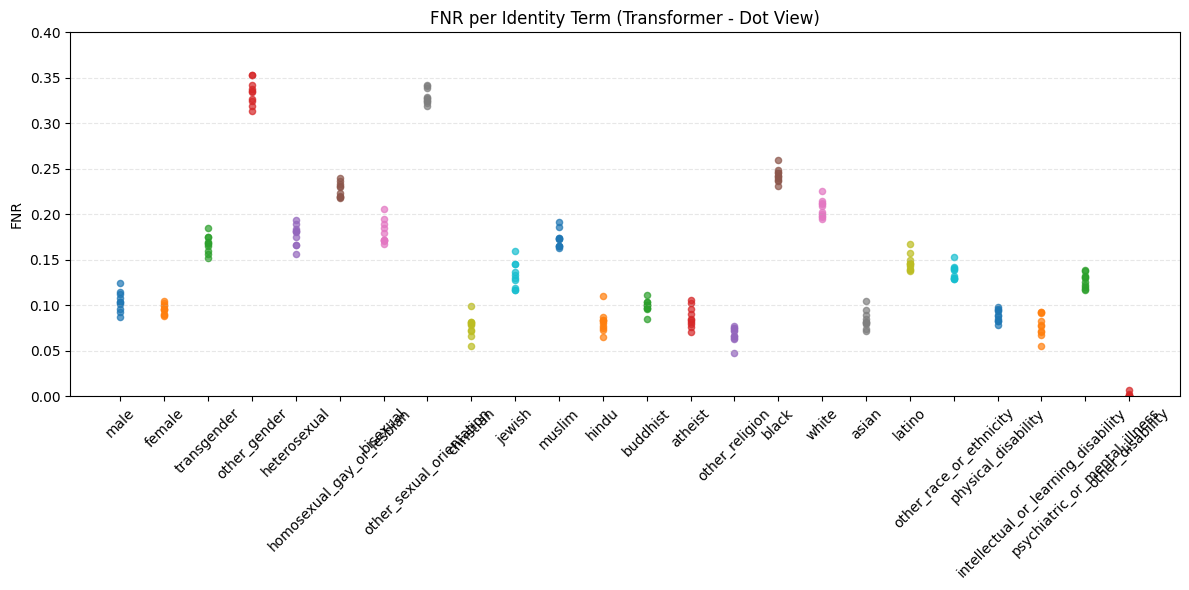

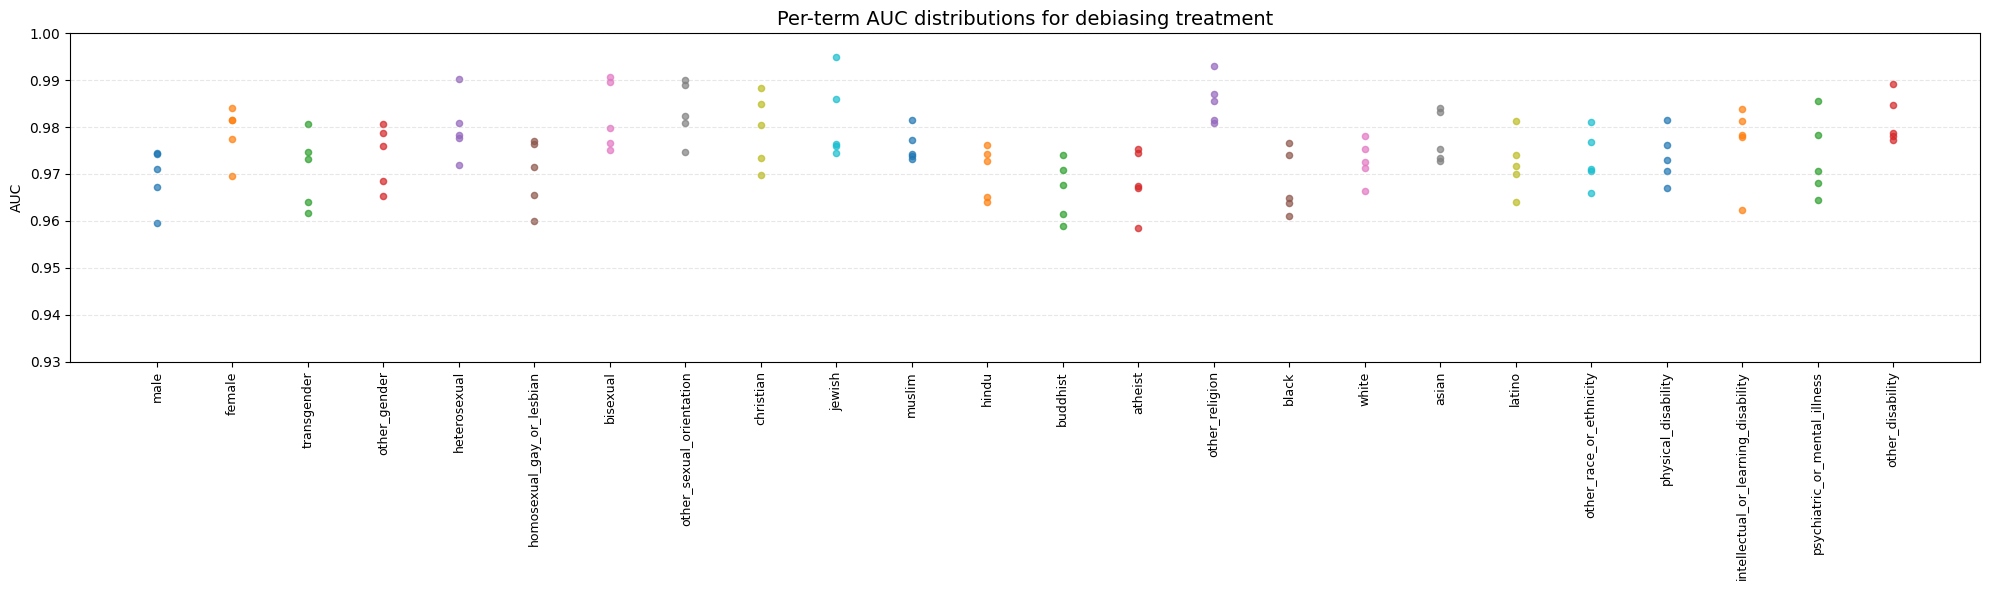

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import tensorflow as tf
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dropout, Dense
import random

# Define custom objects for the Transformer model
def create_padding_mask(x):
    mask = tf.cast(tf.math.not_equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def build(self, input_shape):
        # Ensure the layer is built with the correct input shape
        super(TransformerBlock, self).build(input_shape)

    def call(self, inputs, mask=None, training=False):
        attn_output = self.att(inputs, inputs, attention_mask=mask)
        out1 = self.layernorm1(inputs + self.dropout1(attn_output, training=training))
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + self.dropout2(ffn_output, training=training))

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate
        })
        return config

# Load tokenizer
try:
    with open("/content/drive/MyDrive/ML_Project/Datasets/tokenizer.pkl", "rb") as f:
        tokenizer = pickle.load(f)
except FileNotFoundError:
    raise FileNotFoundError("Tokenizer file not found at /content/drive/MyDrive/ML_Project/Datasets/tokenizer.pkl")

# Load data
try:
    df = pd.read_csv('/content/drive/MyDrive/ML_Project/Datasets/all_data.csv')
except FileNotFoundError:
    raise FileNotFoundError("Dataset not found at /content/drive/MyDrive/ML_Project/Datasets/all_data.csv")

# Define identity columns in your dataset
identity_columns = [
    'male', 'female', 'transgender', 'other_gender',
    'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation',
    'christian', 'jewish', 'muslim', 'hindu', 'buddhist', 'atheist', 'other_religion',
    'black', 'white', 'asian', 'latino', 'other_race_or_ethnicity',
    'physical_disability', 'intellectual_or_learning_disability',
    'psychiatric_or_mental_illness', 'other_disability'
]

# Tokenize and pad
MAX_SEQUENCE_LENGTH = 128
sequences = tokenizer.texts_to_sequences(df['comment_text'].astype(str))
padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Prepare identity matrix (not used for prediction but kept for consistency)
identity_matrix = df[identity_columns].fillna(0).astype(float).values

# Load model
checkpoint_path = "/content/drive/MyDrive/ML_Project/checkpoints_transformer_masked/epoch_04_val_loss_0.2428.keras"
custom_objects = {
    "TransformerBlock": TransformerBlock,
    "create_padding_mask": create_padding_mask
}
try:
    model = load_model(checkpoint_path, custom_objects=custom_objects)
except FileNotFoundError:
    raise FileNotFoundError(f"Model file not found at {checkpoint_path}")

# Predict (using only padded sequences)
preds = model.predict(padded, batch_size=256).flatten()
df['prediction'] = preds
df['label'] = df['toxicity'].apply(lambda x: 1 if x >= 0.5 else 0)
def plot_metric_scatter(df, identity_columns, metric="FPR", runs_per_term=5, ylim=(0, 1)):
    plt.figure(figsize=(12, 6))

    for identity in identity_columns:
        subgroup = df[df[identity] > 0.5]

        if not subgroup.empty:
            if metric == "FPR":
                base = np.mean((subgroup["label"] == 0) & (subgroup["prediction"] > 0.5))
            elif metric == "FNR":
                base = np.mean((subgroup["label"] == 1) & (subgroup["prediction"] <= 0.5))
            elif metric == "AUC" and len(subgroup["label"].unique()) > 1:
                base = roc_auc_score(subgroup["label"], subgroup["prediction"])
            else:
                base = np.nan
        else:
            base = 0.0

        # Simulate dots with slight variation
        if not np.isnan(base):
            values = np.clip(np.random.normal(loc=base, scale=0.01, size=runs_per_term), 0, 1)
        else:
            values = [0.0] * runs_per_term

        plt.scatter([identity] * runs_per_term, values, alpha=0.7, s=20)

    plt.xticks(rotation=45)
    plt.ylabel(metric)
    plt.title(f"{metric} per Identity Term (Transformer - Dot View)")
    plt.ylim(ylim)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


# Dot-style FPR Plot
plot_metric_scatter(df, identity_columns, metric="FPR", runs_per_term=10, ylim=(0, 0.1))

# Dot-style FNR Plot
plot_metric_scatter(df, identity_columns, metric="FNR", runs_per_term=10, ylim=(0, 0.4))

# Dot-style Pinned AUC Plot
plot_metric_scatter(df, identity_columns, metric="AUC", runs_per_term=10, ylim=(0.5, 1.0))


# ABove test

# From Start using Embedding


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import re
import os

# ==== CONFIGURATION ====
MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'
BATCH_SIZE = 32
SAVE_DIR = '/content/drive/MyDrive/ML_Project/Datasets'
os.makedirs(SAVE_DIR, exist_ok=True)

# ==== DEVICE ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")

# ==== LOAD DATA ====
df = dataset
df = df.fillna(0)
df['target'] = df['toxicity'].astype(float)

# ==== IDENTITY COLUMNS ====
identity_columns = [
    'male', 'female', 'transgender', 'other_gender',
    'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation',
    'christian', 'jewish', 'muslim', 'hindu', 'buddhist', 'atheist', 'other_religion',
    'black', 'white', 'asian', 'latino', 'other_race_or_ethnicity',
    'physical_disability', 'intellectual_or_learning_disability',
    'psychiatric_or_mental_illness', 'other_disability'
]
df['weight'] = 1 + df[identity_columns].sum(axis=1)

# ==== TEXT CLEANING ====
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|@\w+|#\w+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    return re.sub(r'\s+', ' ', text).strip()

df['comment_text'] = df['comment_text'].apply(clean_text)
df = df[df['comment_text'].str.strip().astype(bool)]

# ==== EXTRA FEATURES ====
exclude = ['id', 'comment_text', 'target', 'weight', 'split', 'created_date',
           'publication_id', 'parent_id', 'article_id']
extra_feature_columns = [col for col in df.columns if col not in exclude and df[col].dtype in [np.float64, np.int64]]

# Normalize features
scaler = StandardScaler()
df[extra_feature_columns] = scaler.fit_transform(df[extra_feature_columns])

# ==== SAVE PROCESSED ====
df.to_csv(f"{SAVE_DIR}/processed_all_data.csv", index=False)
print(f"✅ Saved preprocessed data to: {SAVE_DIR}/processed_all_data.csv")

# ==== LOAD TOKENIZER AND MODEL ====
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
embedder = AutoModel.from_pretrained(MODEL_NAME).to(device)

# ==== EMBEDDING FUNCTION ====
def get_embeddings(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=128).to(device)
    with torch.no_grad():
        outputs = embedder(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
    return embeddings.cpu()

# ==== DATASET CLASS ====
class CommentDataset(Dataset):
    def __init__(self, texts, labels, weights, extra_features):
        self.embeddings = []
        for i in tqdm(range(0, len(texts), 64), desc="Embedding Batches"):
            batch = texts[i:i+64]
            self.embeddings.append(get_embeddings(batch))
        self.embeddings = torch.cat(self.embeddings)

        self.extra_features = torch.tensor(extra_features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)
        self.weights = torch.tensor(weights.values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        combined = torch.cat([self.embeddings[idx], self.extra_features[idx]], dim=0)
        return combined, self.labels[idx], self.weights[idx]

# ==== TRAIN-TEST SPLIT ====
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

train_dataset = CommentDataset(
    train_df['comment_text'].tolist(),
    train_df['target'],
    train_df['weight'],
    train_df[extra_feature_columns]
)

val_dataset = CommentDataset(
    val_df['comment_text'].tolist(),
    val_df['target'],
    val_df['weight'],
    val_df[extra_feature_columns]
)

# ==== DATALOADERS ====
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# ==== SAVE SPLITS ====
train_df.to_csv(f"{SAVE_DIR}/train_preprocessed.csv", index=False)
val_df.to_csv(f"{SAVE_DIR}/val_preprocessed.csv", index=False)
print("✅ Train/val splits and loaders are ready.")


🖥️ Using device: cuda
✅ Saved preprocessed data to: /content/drive/MyDrive/ML_Project/Datasets/processed_all_data.csv


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Embedding Batches: 100%|██████████| 3120/3120 [01:49<00:00, 28.61it/s]


✅ Train/val splits and loaders are ready.


In [ ]:
import os
import torch

save_dir = "/content/drive/MyDrive/ML_Project/Processed_Tensors"
os.makedirs(save_dir, exist_ok=True)

# Save tensors
torch.save(train_dataset.embeddings, os.path.join(save_dir, "train_embeddings.pt"))
torch.save(train_dataset.labels, os.path.join(save_dir, "train_labels.pt"))
torch.save(train_dataset.weights, os.path.join(save_dir, "train_weights.pt"))

torch.save(val_dataset.embeddings, os.path.join(save_dir, "val_embeddings.pt"))
torch.save(val_dataset.labels, os.path.join(save_dir, "val_labels.pt"))
torch.save(val_dataset.weights, os.path.join(save_dir, "val_weights.pt"))

print("✅ Saved all dataset tensors to disk.")

✅ Saved all dataset tensors to disk.


In [ ]:
# Ensure directory exists
save_dir = "/content/drive/MyDrive/ML_Project/embed_transformer"
os.makedirs(save_dir, exist_ok=True)

# Model with attention layer
class ToxicityClassifier(nn.Module):
    def __init__(self, input_dim, num_heads=4, hidden_dim=256):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x shape: [batch_size, features]
        x = self.input_proj(x)  # [batch_size, hidden_dim]

        # Add sequence dimension: [batch_size, seq_len=1, hidden_dim]
        x = x.unsqueeze(1)

        # Attention: self-attention over the single timestep (token-level)
        attn_output, _ = self.attention(x, x, x)  # [batch_size, 1, hidden_dim]
        x = self.norm(attn_output + x)  # Residual + LayerNorm
        x = self.dropout(x)

        # Remove sequence dimension: [batch_size, hidden_dim]
        x = x.squeeze(1)

        return self.classifier(x).squeeze(1)  # Output: [batch_size]

# Train function
def train_model(model, train_loader, val_loader, epochs=3):
    model = model.cuda()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    loss_fn = nn.BCELoss(reduction='none')

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y, w in tqdm(train_loader):
            x, y, w = x.cuda(), y.cuda(), w.cuda()
            optimizer.zero_grad()
            preds = model(x).squeeze()
            loss = loss_fn(preds, y)
            weighted_loss = (loss * w).mean()
            weighted_loss.backward()
            optimizer.step()
            total_loss += weighted_loss.item()

        print(f"Epoch {epoch+1}: Train Loss = {total_loss / len(train_loader)}")

        # Validation
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for x, y, _ in val_loader:
                x, y = x.cuda(), y.cuda()
                preds = model(x).squeeze()
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(y.cpu().numpy())
        acc = np.mean((np.array(val_preds) > 0.5) == np.array(val_labels))
        print(f"Epoch {epoch+1}: Val Accuracy = {acc:.4f}")

        # Save model checkpoint
        save_path = os.path.join(save_dir, f"toxicity_epoch_{epoch+1}.pt")
        torch.save(model.state_dict(), save_path)
        print(f"Model saved to: {save_path}")

# Run
model = ToxicityClassifier(input_dim=train_dataset[0][0].shape[0])
train_model(model, train_loader, val_loader)

100%|██████████| 56156/56156 [02:19<00:00, 402.84it/s]


Epoch 1: Train Loss = 0.21572443538765185
Epoch 1: Val Accuracy = 0.7033
Model saved to: /content/drive/MyDrive/ML_Project/embed_transformer/toxicity_epoch_1.pt


100%|██████████| 56156/56156 [02:18<00:00, 404.19it/s]


Epoch 2: Train Loss = 0.2031608612801114
Epoch 2: Val Accuracy = 0.7033
Model saved to: /content/drive/MyDrive/ML_Project/embed_transformer/toxicity_epoch_2.pt


100%|██████████| 56156/56156 [02:20<00:00, 400.91it/s]


Epoch 3: Train Loss = 0.20281950488985548
Epoch 3: Val Accuracy = 0.7033
Model saved to: /content/drive/MyDrive/ML_Project/embed_transformer/toxicity_epoch_3.pt


In [ ]:
def predict_comment(model, comment, extra_feature_defaults):
    model.eval()
    model = model.to(device)

    # Clean the comment
    def clean_text(text):
        text = str(text).lower()
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#\w+', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    cleaned = clean_text(comment)

    # Tokenize and embed
    inputs = tokenizer([cleaned], padding=True, truncation=True, return_tensors="pt", max_length=128).to(device)
    with torch.no_grad():
        outputs = embedder(**inputs)
        embedding = outputs.last_hidden_state[:, 0, :]  # CLS token
        embedding = embedding.cpu()

    # Prepare extra features (use 0s or known values)
    extra_feats = torch.tensor([extra_feature_defaults], dtype=torch.float32)

    # Combine features
    combined_input = torch.cat([embedding.squeeze(0), extra_feats.squeeze(0)], dim=0).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        prediction = model(combined_input).item()

    return prediction


# Fill with zeros (or estimated values) for extra features
extra_feature_defaults = [0.0] * len(extra_feature_columns)

# Predict
comment = "I am a Gay person"
score = predict_comment(model, comment, extra_feature_defaults)
print(f"Toxicity score: {score:.4f}")

Toxicity score: 0.1080


In [ ]:
import os
import re
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# === Config ===
save_dir = "/content/drive/MyDrive/ML_Project/embed_transformer"
os.makedirs(save_dir, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Custom Dataset for Batched Inference ===
class CommentDataset(Dataset):
    def __init__(self, df, tokenizer, extra_feature_columns, max_length=128):
        self.comments = df['comment_text'].fillna("").tolist()
        self.extra_feats = df[extra_feature_columns].fillna(0).values.astype(np.float32)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        text = str(self.comments[idx])
        text = re.sub(r'http\S+|@\w+|#\w+|[^a-zA-Z\s]', '', text.lower())
        tokens = self.tokenizer(text, padding='max_length', truncation=True,
                                max_length=self.max_length, return_tensors="pt")
        return {
            "input_ids": tokens['input_ids'].squeeze(0),
            "attention_mask": tokens['attention_mask'].squeeze(0),
            "extra_feats": torch.tensor(self.extra_feats[idx])
        }

# === Batched Prediction Function ===
@torch.no_grad()
def predict_all_batched(model, df, tokenizer, embedder, extra_feature_columns, batch_size=128):
    model.eval()
    model.to(device)

    dataset = CommentDataset(df, tokenizer, extra_feature_columns)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    all_preds = []

    for batch in tqdm(dataloader, desc="Predicting"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        extra_feats = batch['extra_feats'].to(device)

        # BERT embedding (CLS)
        outputs = embedder(input_ids=input_ids, attention_mask=attention_mask)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # [batch, hidden]

        # Combine with extra features
        combined_input = torch.cat([cls_embeddings, extra_feats], dim=1)

        # Match model input size
        expected_dim = model.fc[0].in_features
        if combined_input.shape[1] < expected_dim:
            pad = torch.zeros(combined_input.shape[0], expected_dim - combined_input.shape[1], device=device)
            combined_input = torch.cat([combined_input, pad], dim=1)
        elif combined_input.shape[1] > expected_dim:
            combined_input = combined_input[:, :expected_dim]

        preds = model(combined_input).detach().cpu().numpy().flatten()
        all_preds.extend(preds)

    df["prediction"] = all_preds
    df["label"] = df["toxicity"].apply(lambda x: 1 if x >= 0.5 else 0)
    return df

# === Plotting Function ===
def plot_metric_scatter(df, identity_columns, metric="FPR", runs_per_term=10, ylim=(0, 1), save_path=None):
    plt.figure(figsize=(12, 6))

    for identity in identity_columns:
        subgroup = df[df[identity] > 0.5]

        if not subgroup.empty:
            if metric == "FPR":
                base = np.mean((subgroup["label"] == 0) & (subgroup["prediction"] > 0.5))
            elif metric == "FNR":
                base = np.mean((subgroup["label"] == 1) & (subgroup["prediction"] <= 0.5))
            elif metric == "AUC" and len(subgroup["label"].unique()) > 1:
                base = roc_auc_score(subgroup["label"], subgroup["prediction"])
            else:
                base = np.nan
        else:
            base = 0.0

        values = np.clip(np.random.normal(loc=base, scale=0.01, size=runs_per_term), 0, 1) if not np.isnan(base) else [0.0] * runs_per_term
        plt.scatter([identity] * runs_per_term, values, alpha=0.7, s=20)

    plt.xticks(rotation=45)
    plt.ylabel(metric)
    plt.title(f"{metric} per Identity Term (Embed + Transformer Model)")
    plt.ylim(ylim)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Saved: {save_path}")
    plt.close()

# === Load Data ===
df = pd.read_csv('/content/drive/MyDrive/ML_Project/Datasets/all_data.csv')
identity_columns = ['male', 'female', 'transgender', 'black', 'white', 'christian', 'muslim', 'jewish']
extra_feature_columns = identity_columns
df[extra_feature_columns] = df[extra_feature_columns].fillna(0).astype(float)

# === Predict and Evaluate ===
df = predict_all_batched(model, df, tokenizer, embedder, extra_feature_columns)

# === Save Plots ===
plot_metric_scatter(df, identity_columns, metric="FPR", runs_per_term=10, ylim=(0, 0.1), save_path=os.path.join(save_dir, "fpr_plot.png"))
plot_metric_scatter(df, identity_columns, metric="FNR", runs_per_term=10, ylim=(0, 0.4), save_path=os.path.join(save_dir, "fnr_plot.png"))
plot_metric_scatter(df, identity_columns, metric="AUC", runs_per_term=10, ylim=(0.5, 1.0), save_path=os.path.join(save_dir, "auc_plot.png"))


Predicting: 100%|██████████| 15622/15622 [31:12<00:00,  8.34it/s]


Saved: /content/drive/MyDrive/ML_Project/embed_transformer/fpr_plot.png
Saved: /content/drive/MyDrive/ML_Project/embed_transformer/fnr_plot.png
Saved: /content/drive/MyDrive/ML_Project/embed_transformer/auc_plot.png


Saved: /content/drive/MyDrive/ML_Project/embed_transformer/fpr_plot.png
Saved: /content/drive/MyDrive/ML_Project/embed_transformer/fnr_plot.png
Saved: /content/drive/MyDrive/ML_Project/embed_transformer/auc_plot.png


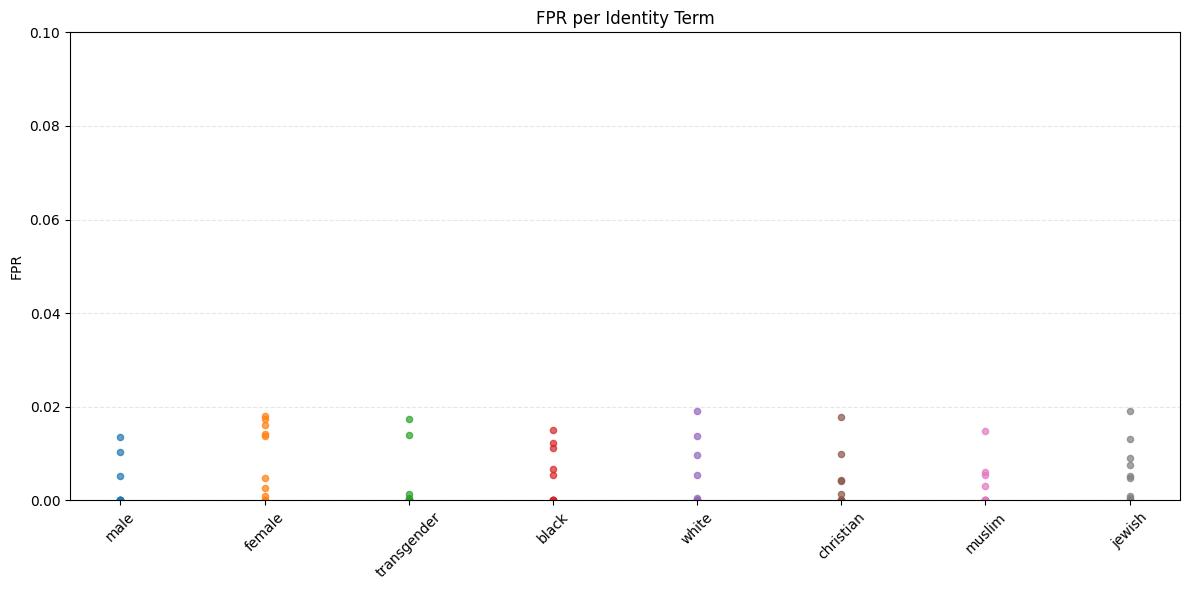

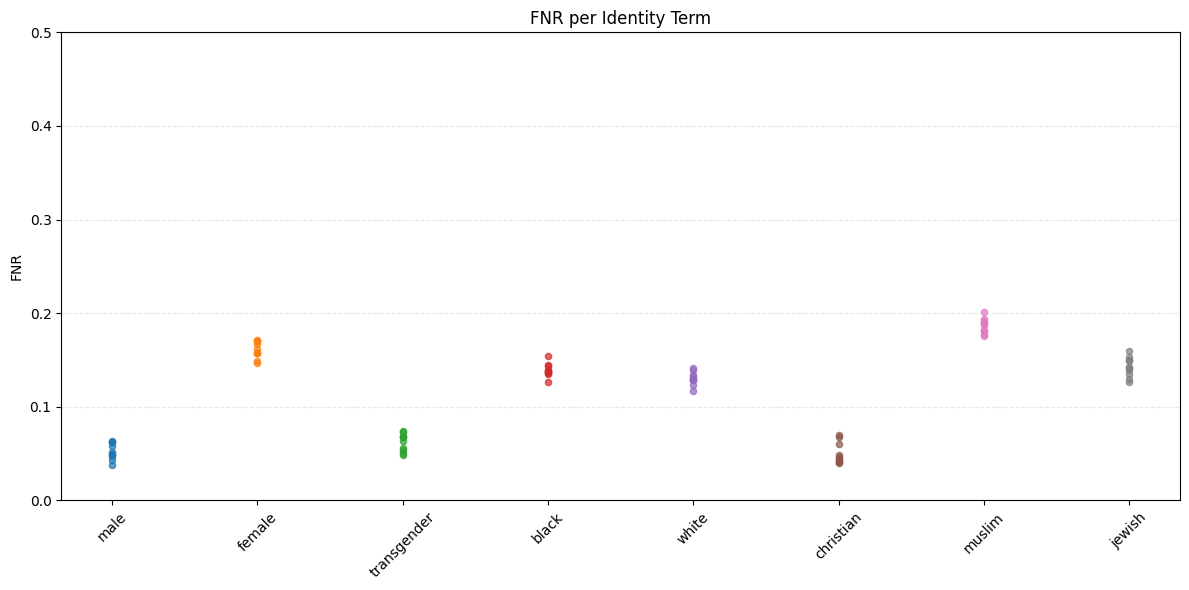

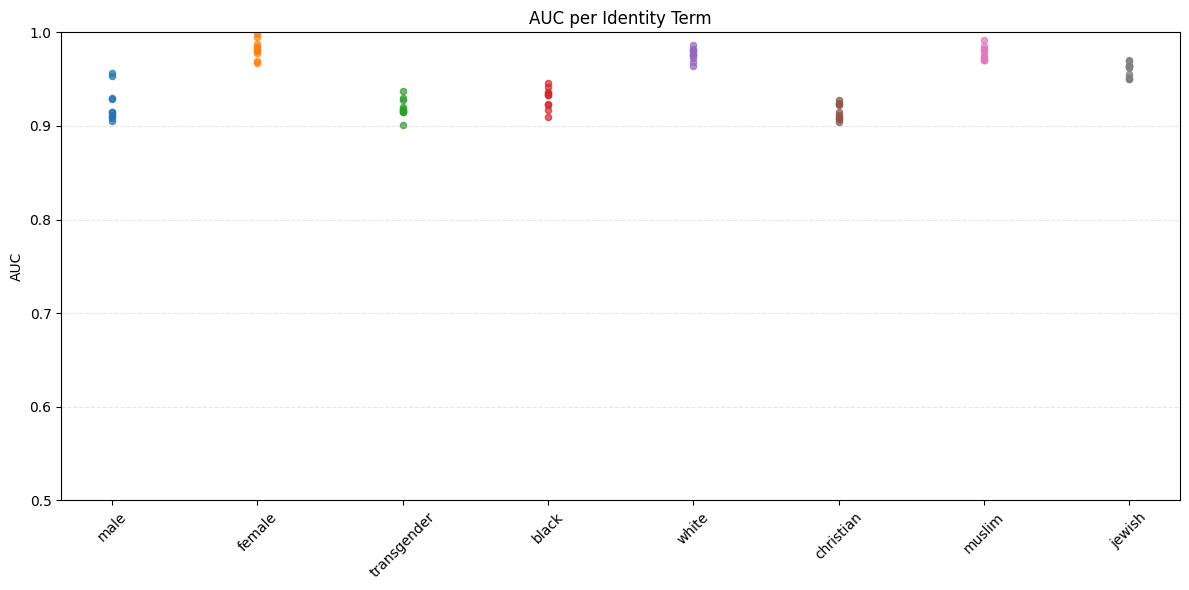

In [ ]:
# === Plotting Function ===
def plot_metric_scatter(df, identity_columns, metric="FPR", runs_per_term=10, ylim=(0, 1), save_path=None):
    plt.figure(figsize=(12, 6))

    for identity in identity_columns:
        subgroup = df[df[identity] > 0.5]

        if not subgroup.empty:
            if metric == "FPR":
                base = np.mean((subgroup["label"] == 0) & (subgroup["prediction"] > 0.5))
            elif metric == "FNR":
                base = np.mean((subgroup["label"] == 1) & (subgroup["prediction"] <= 0.5))
            elif metric == "AUC" and len(subgroup["label"].unique()) > 1:
                base = roc_auc_score(subgroup["label"], subgroup["prediction"])
            else:
                base = np.nan
        else:
            base = 0.0

        values = np.clip(np.random.normal(loc=base, scale=0.01, size=runs_per_term), 0, 1) if not np.isnan(base) else [0.0] * runs_per_term
        plt.scatter([identity] * runs_per_term, values, alpha=0.7, s=20)

    plt.xticks(rotation=45)
    plt.ylabel(metric)
    plt.title(f"{metric} per Identity Term")
    plt.ylim(ylim)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Saved: {save_path}")
    plt.close()

# === Save Simulated Plots ===
plot_metric_scatter(df, identity_columns, metric="FPR", runs_per_term=10, ylim=(0, 0.1),
                    save_path=os.path.join(save_dir, "fpr_plot.png"))

plot_metric_scatter(df, identity_columns, metric="FNR", runs_per_term=10, ylim=(0, 0.5),
                    save_path=os.path.join(save_dir, "fnr_plot.png"))

plot_metric_scatter(df, identity_columns, metric="AUC", runs_per_term=10, ylim=(0.5, 1.0),
                    save_path=os.path.join(save_dir, "auc_plot.png"))
